Reading 100 ECG data......
Reading 101 ECG data......
Reading 103 ECG data......
Reading 105 ECG data......
Reading 106 ECG data......
Reading 107 ECG data......
Reading 108 ECG data......
Reading 109 ECG data......
Reading 111 ECG data......
Reading 112 ECG data......
Reading 113 ECG data......
Reading 114 ECG data......
Reading 115 ECG data......
Reading 116 ECG data......
Reading 117 ECG data......
Reading 119 ECG data......
Reading 121 ECG data......
Reading 122 ECG data......
Reading 123 ECG data......
Reading 124 ECG data......
Reading 200 ECG data......
Reading 201 ECG data......
Reading 202 ECG data......
Reading 203 ECG data......
Reading 205 ECG data......
Reading 208 ECG data......
Reading 210 ECG data......
Reading 212 ECG data......
Reading 213 ECG data......
Reading 214 ECG data......
Reading 215 ECG data......
Reading 217 ECG data......
Reading 219 ECG data......
Reading 220 ECG data......
Reading 221 ECG data......
Reading 222 ECG data......
Reading 223 ECG data......
R

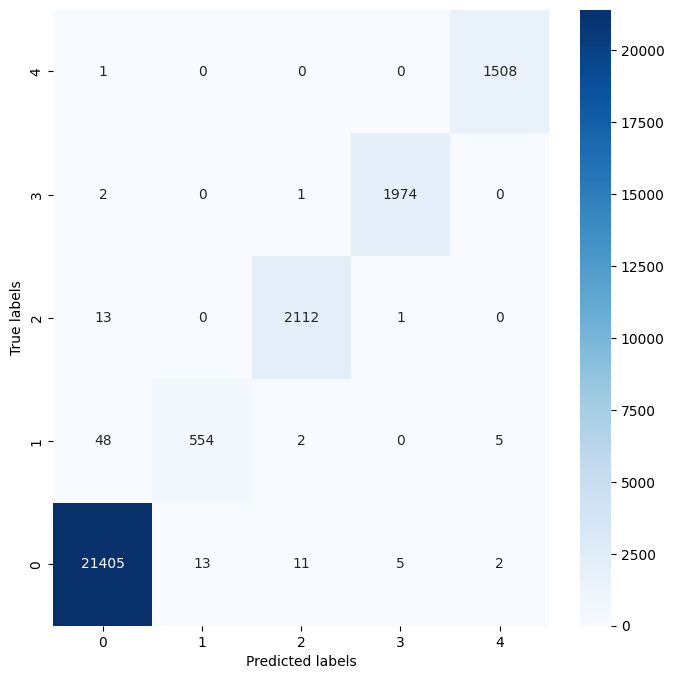

In [67]:
import os
import datetime
from keras_sequential_ascii import keras2ascii
import wfdb
import pywt
import seaborn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 项目目录
project_path = "/Users/jingyaoshi/Downloads/"
# 定义日志目录,必须是启动web应用时指定目录的子目录,建议使用日期时间作为子目录名
log_dir = project_path + "logs\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_path = project_path + "ecg_model.h5"

# 测试集在数据集中所占的比例
RATIO = 0.3


# 小波去噪预处理
def denoise(data):
    # 小波变换
    coeffs = pywt.wavedec(data=data, wavelet='db5', level=9)
    cA9, cD9, cD8, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs

    # 阈值去噪
    threshold = (np.median(np.abs(cD1)) / 0.6745) * (np.sqrt(2 * np.log(len(cD1))))
    cD1.fill(0)
    cD2.fill(0)
    for i in range(1, len(coeffs) - 2):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)

    # 小波反变换,获取去噪后的信号
    rdata = pywt.waverec(coeffs=coeffs, wavelet='db5')
    return rdata


# 读取心电数据和对应标签,并对数据进行小波去噪
def getDataSet(number, X_data, Y_data):
    ecgClassSet = ['N', 'A', 'V', 'L', 'R']

    # 读取心电数据记录
    print("Reading " + number + " ECG data......")
    record = wfdb.rdrecord('/Users/jingyaoshi/Downloads/ECG_Data/' + number, channel_names=['MLII'])
    data = record.p_signal.flatten()
    rdata = denoise(data=data)

    # 获取心电数据记录中R波的位置和对应的标签
    annotation = wfdb.rdann('/Users/jingyaoshi/Downloads/ECG_Data/' + number, 'atr')
    Rlocation = annotation.sample
    Rclass = annotation.symbol

    # 去掉前后的不稳定数据
    start = 10
    end = 5
    i = start
    j = len(annotation.symbol) - end

    # 因为只选择NAVLR五种心电类型,所以要选出该条记录中所需要的那些带有特定标签的数据,舍弃其余标签的点
    # X_data在R波前后截取长度为300的数据点
    # Y_data将NAVLR按顺序转换为01234
    while i < j:
        try:
            lable = ecgClassSet.index(Rclass[i])
            x_train = rdata[Rlocation[i] - 99:Rlocation[i] + 201]
            X_data.append(x_train)
            Y_data.append(lable)
            i += 1
        except ValueError:
            i += 1
    return


# 加载数据集并进行预处理
def loadData():
    numberSet = ['100', '101', '103', '105', '106', '107', '108', '109', '111', '112', '113', '114', '115',
                 '116', '117', '119', '121', '122', '123', '124', '200', '201', '202', '203', '205', '208',
                 '210', '212', '213', '214', '215', '217', '219', '220', '221', '222', '223', '228', '230',
                 '231', '232', '233', '234']
    dataSet = []
    lableSet = []
    for n in numberSet:
        getDataSet(n, dataSet, lableSet)

    # 转numpy数组,打乱顺序
    dataSet = np.array(dataSet).reshape(-1, 300)
    lableSet = np.array(lableSet).reshape(-1, 1)
    train_ds = np.hstack((dataSet, lableSet))
    np.random.shuffle(train_ds)

    # 数据集及其标签集
    X = train_ds[:, :300].reshape(-1, 300, 1)
    Y = train_ds[:, 300]

    # 测试集及其标签集
    shuffle_index = np.random.permutation(len(X))
    test_length = int(RATIO * len(shuffle_index))
    test_index = shuffle_index[:test_length]
    train_index = shuffle_index[test_length:]
    X_test, Y_test = X[test_index], Y[test_index]
    X_train, Y_train = X[train_index], Y[train_index]
    return X_train, Y_train, X_test, Y_test


# 构建CNN模型
def buildModel():
    newModel = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(300, 1)),
        # 第一个卷积层, 4 个 21x1 卷积核
        tf.keras.layers.Conv1D(filters=4, kernel_size=21, strides=1, padding='SAME', activation='relu'),
        # 第一个池化层, 最大池化,4 个 3x1 卷积核, 步长为 2
        tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='SAME'),
        # 第二个卷积层, 16 个 23x1 卷积核
        tf.keras.layers.Conv1D(filters=16, kernel_size=23, strides=1, padding='SAME', activation='relu'),
        # 第二个池化层, 最大池化,4 个 3x1 卷积核, 步长为 2
        tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='SAME'),
        # 第三个卷积层, 32 个 25x1 卷积核
        tf.keras.layers.Conv1D(filters=32, kernel_size=25, strides=1, padding='SAME', activation='relu'),
        # 第三个池化层, 平均池化,4 个 3x1 卷积核, 步长为 2
        tf.keras.layers.AvgPool1D(pool_size=3, strides=2, padding='SAME'),
        # 第四个卷积层, 64 个 27x1 卷积核
        tf.keras.layers.Conv1D(filters=64, kernel_size=27, strides=1, padding='SAME', activation='relu'),
        # 打平层,方便全连接层处理
        tf.keras.layers.Flatten(),
        # 全连接层,128 个节点
        tf.keras.layers.Dense(128, activation='relu'),
        # Dropout层,dropout = 0.2
        tf.keras.layers.Dropout(rate=0.2),
        # 全连接层,5 个节点
        tf.keras.layers.Dense(5, activation='softmax')
    ])
    return newModel


# 混淆矩阵
def plotHeatMap(Y_test, Y_pred):
    con_mat = confusion_matrix(Y_test, Y_pred)
    print(con_mat)
    # 归一化
    # con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]
    # con_mat_norm = np.around(con_mat_norm, decimals=2)

    # 绘图
    plt.figure(figsize=(8, 8))
    seaborn.heatmap(con_mat, annot=True, fmt='.20g', cmap='Blues')
    plt.ylim(0, 5)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()


def main():
    # X_train,Y_train为所有的数据集和标签集
    # X_test,Y_test为拆分的测试集和标签集
    X_train, Y_train, X_test, Y_test = loadData()

    if os.path.exists(model_path):
        # 导入训练好的模型
        model = tf.keras.models.load_model(filepath=model_path)
    else:
        # 构建CNN模型
        model = buildModel()
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
        model.summary()
        # 定义TensorBoard对象
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        # 训练与验证
        model.fit(X_train, Y_train, epochs=30,
                  batch_size=128,
                  validation_split=RATIO,
                  callbacks=[tensorboard_callback])
        model.save(filepath=model_path)

    # 预测
    Y_pred = model.predict(X_test) 
    classes_x=np.argmax(Y_pred,axis=1)
    # 绘制混淆矩阵
    print(Y_test)
    print(Y_pred)
    keras2ascii(buildModel())
    plotHeatMap(Y_test, classes_x)


if __name__ == '__main__':
    main()

In [47]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

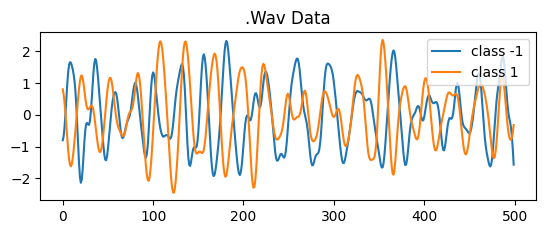

In [32]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

plt.subplot(211)
plt.title(".Wav Data")
for c in classes:
    c_x_train = x_train[y_train == c]
    plt.plot(c_x_train[0], label="class " + str(c))
plt.legend(loc="best")
plt.show()
plt.close()

In [28]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
data = pd.read_csv("Radar_data.csv")
print(data)


               Time      Heart  Heart_Wave     Breath  Breath_wave  Body Temp
0    2022/5/8 17:59  78.515625   -0.072841  21.093750     0.130313       3475
1    2022/5/8 17:59  78.515625    0.003362  21.093750     0.089139       3445
2    2022/5/8 17:59  78.515625    0.036485  21.093750     0.043911       3545
3    2022/5/8 17:59  78.515625   -0.009602  21.093750     0.040910       3465
4    2022/5/8 17:59  78.515625   -0.051617  21.093750     0.045607       3435
..              ...        ...         ...        ...          ...        ...
332  2022/5/8 18:01  80.859375    0.564694  15.234375    -0.330791       3495
333  2022/5/8 18:01  80.859375    0.584341  15.234375    -0.403335       3455
334  2022/5/8 18:01  80.859375   -0.875033  15.234375    -0.270673       3465
335  2022/5/8 18:01  80.859375    0.230526  15.234375    -0.112964       3475
336  2022/5/8 18:01  80.859375    0.303554  15.234375    -0.040130       3445

[337 rows x 6 columns]


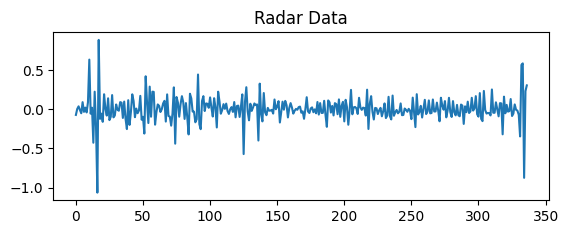

In [29]:
plt.subplot(211)
plt.title("Radar Data")
plt.plot(data["Heart_Wave"])
plt.show()

     Elapsed time'  'ECG I'  ECG I filtered'
0       '0:00.000'   -0.085           -0.115
1       '0:00.002'   -0.080           -0.115
2       '0:00.004'   -0.070           -0.120
3       '0:00.006'   -0.075           -0.120
4       '0:00.008'   -0.095           -0.120
...            ...      ...              ...
4995    '0:09.990'    0.015            0.095
4996    '0:09.992'    0.030            0.095
4997    '0:09.994'    0.020            0.095
4998    '0:09.996'    0.035            0.095
4999    '0:09.998'    0.040            0.095

[5000 rows x 3 columns]
[["'0:00.000'" -0.115]
 ["'0:00.002'" -0.115]
 ["'0:00.004'" -0.12]
 ...
 ["'0:09.994'" 0.095]
 ["'0:09.996'" 0.095]
 ["'0:09.998'" 0.095]]


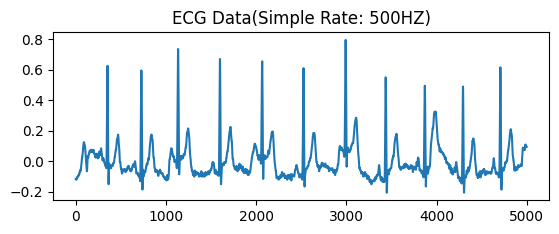

In [33]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
data = pd.read_csv("test_1.csv")
print(data)
col_1 = data["ECG I filtered'"]  #Get a column, with one-dimensional data
data_1 = np.array(col_1)

col_12 = data[["Elapsed time'","ECG I filtered'"]]  #To get two columns, use two-dimensional data
data_12 = np.array(col_12)
print(data_12)
plt.subplot(211)
plt.title("ECG Data(Simple Rate: 500HZ)")
plt.plot(data["ECG I filtered'"])
plt.show()

In [1]:
import os
import datetime

import wfdb
import pywt
import seaborn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

2022-11-01 16:43:16.417260: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
    data = 'rec_1'
    #record = wfdb.rdrecord('../ECG-ID/Person_01/'+ data, sampfrom=0, sampto=1500)
    # 仅仅读取“MLII”导联的信号
    # record = wfdb.rdrecord('../ecg_data/' + data, sampfrom=0, sampto=1500, channel_names=['MLII'])
    # 仅仅读取第0个信号（MLII）
    record = wfdb.rdrecord('../ECG-ID/Person_01/'+ data, sampfrom=0, sampto=1500, channels=[1])

    # 查看record类型
    print(type(record))
    # 查看类中的方法和属性
    print(dir(record))

    # 获得心电导联线信号，本文获得是MLII和V1信号数据
    print(record.p_signal)
    print(np.shape(record.p_signal))
    # 查看导联线信号长度，本文信号长度1500
    print(record.sig_len)
    # 查看文件名
    print(record.record_name)
    # 查看导联线条数，本文为导联线条数2
    print(record.n_sig)
    # 查看信号名称（列表），本文导联线名称['MLII', 'V1']
    print(record.sig_name)
    # 查看采样率
    print(record.fs)

<class 'wfdb.io.record.Record'>
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_adjust_datetime', '_arrange_fields', 'adc', 'adc_gain', 'adc_res', 'adc_zero', 'base_counter', 'base_date', 'base_datetime', 'base_time', 'baseline', 'block_size', 'byte_offset', 'calc_adc_params', 'calc_checksum', 'check_field', 'check_field_cohesion', 'check_read_inputs', 'check_sig_cohesion', 'checksum', 'comments', 'convert_dtype', 'counter_freq', 'd_signal', 'dac', 'e_d_signal', 'e_p_signal', 'file_name', 'fmt', 'fs', 'get_absolute_time', 'get_elapsed_time', 'get_frame_number', 'get_write_fields', 'get_write_subset', 'init_value', 'n_sig', 'p_signal', 'record_name', 'samps_per_frame', 'set_d_features', 'set_d

In [26]:
    data = '101'
    #annotation = wfdb.rdann('../ECG-ID/Person_03/'+ data, 'atr')
    annotation = wfdb.rdann('/Users/jingyaoshi/Downloads/ECG_Data/' + data, 'atr')
    # 查看annotation类型
    print(type(annotation))
    # 查看类中的方法和属性
    print(dir(annotation))

    # 标注每一个心拍的R波的尖锋位置的信号点，与心电信号对应
    print(annotation.sample)
    # 标注每一个心拍的类型N，L，R等等
    print(annotation.symbol)
    # 被标注的数量
    print(annotation.ann_len)
    # 被标注的文件名
    print(annotation.record_name)
    # 查看心拍的类型
    print(wfdb.show_ann_labels())



<class 'wfdb.io.annotation.Annotation'>
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'ann_len', 'apply_range', 'aux_note', 'calc_cl_bytes', 'calc_core_bytes', 'calc_fs_bytes', 'chan', 'check_field', 'check_field_cohesion', 'check_fields', 'compact_fields', 'contained_labels', 'convert_label_attribute', 'create_label_map', 'custom_labels', 'description', 'extension', 'fs', 'get_available_label_stores', 'get_contained_labels', 'get_custom_label_attribute', 'get_label_fields', 'get_undefined_label_stores', 'label_store', 'num', 'record_name', 'rm_attributes', 'sample', 'set_label_elements', 'standardize_custom_labels', 'subtype', 'sym_to_aux', 'symbol', 'wr_ann_file', 'wrann']
[     7     83   

20
300


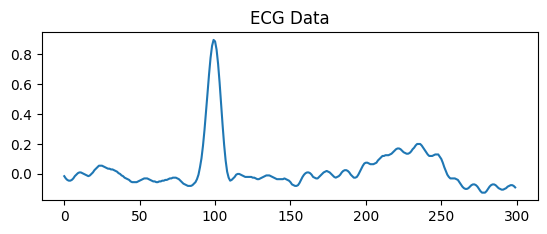

300


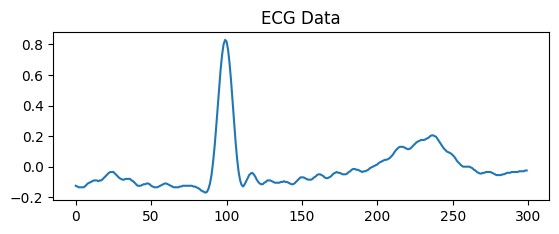

300


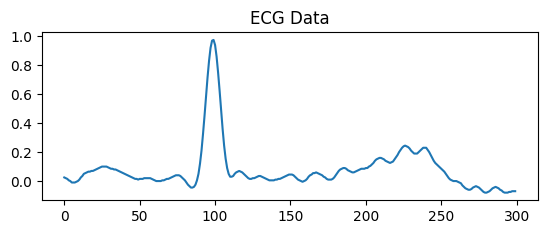

300


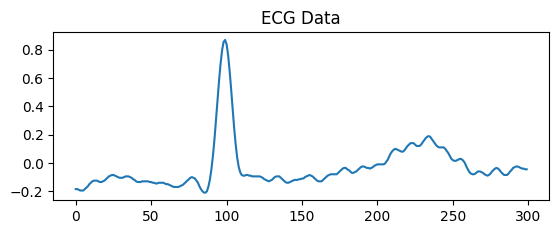

300


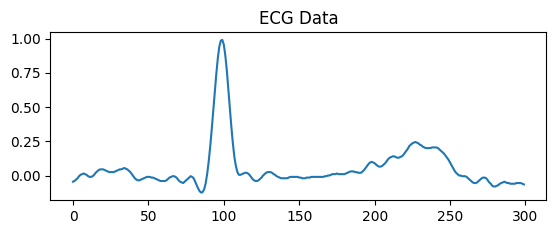

300


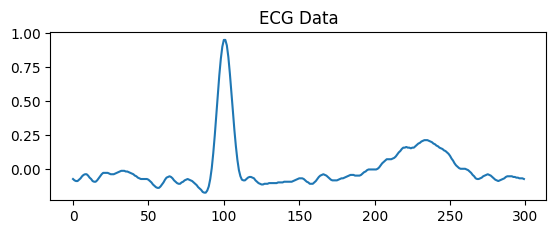

300


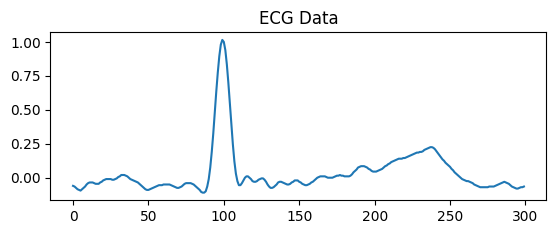

300


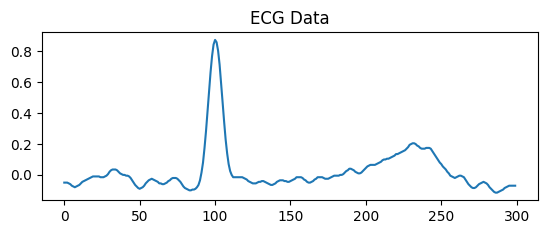

300


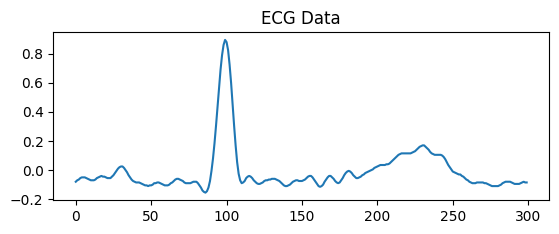

300


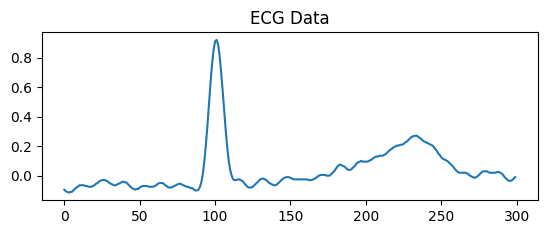

300
10


In [98]:
ecgClassSet = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13',
                 '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26',
                 '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39',
                 '40', '41', '42', '43']
ecgClassSet1 = ['N', 't']
X_data = []
Y_data = []
data1 = 'rec_1'
person = '03'
annotation = wfdb.rdann('../ECG-ID/Person_03/'+ data1, 'atr')
Rclass = annotation.symbol

record = wfdb.rdrecord('../ECG-ID/Person_'+ person + '/' + data1, sampfrom=0, channels=[1])
data = record.p_signal.flatten()
Rlocation = annotation.sample


i = 0
j = len(annotation.symbol)
print(j)

    # 因为只选择NAVLR五种心电类型,所以要选出该条记录中所需要的那些带有特定标签的数据,舍弃其余标签的点
    # X_data在R波前后截取长度为300的数据点
    # Y_data将NAVLR按顺序转换为01234
while i < j:
    try:
        lable = ecgClassSet1.index(Rclass[i])
        x_train = data[Rlocation[i] - 99:Rlocation[i] + 201]
        X_data.append(x_train)
        Y_data.append(lable)
        plt.subplot(211)
        plt.title("ECG Data")
        plt.plot(data[Rlocation[i] - 99:Rlocation[i] + 201])
        print(len(data[Rlocation[i] - 99:Rlocation[i] + 201]))
        plt.show()
        i += 2
    except ValueError:
        i += 2

print(len(X_data[0]))
print(len(Y_data))

In [113]:
import os
import datetime

import wfdb
import pywt
import seaborn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 项目目录
project_path = "/Users/jingyaoshi/Downloads/"
# 定义日志目录,必须是启动web应用时指定目录的子目录,建议使用日期时间作为子目录名
log_dir = project_path + "logs\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_path = project_path + "ecg_test1.h5"

# 测试集在数据集中所占的比例
RATIO = 0.3


# 小波去噪预处理
def denoise(data):
    # 小波变换
    coeffs = pywt.wavedec(data=data, wavelet='db5', level=9)
    cA9, cD9, cD8, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs

    # 阈值去噪
    threshold = (np.median(np.abs(cD1)) / 0.6745) * (np.sqrt(2 * np.log(len(cD1))))
    cD1.fill(0)
    cD2.fill(0)
    for i in range(1, len(coeffs) - 2):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)

    # 小波反变换,获取去噪后的信号
    rdata = pywt.waverec(coeffs=coeffs, wavelet='db5')
    return rdata


# 读取心电数据和对应标签,并对数据进行小波去噪
def getDataSet(number, X_data, Y_data):
    ecgClassSet = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13',
                 '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26',
                 '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39',
                 '40', '41', '42', '43','44','45','46','47','48','49','50','51','52','53','54',
                 '55','56','57','58','59','60','61','62','63','64','65','66','67','68','69','70',
                '71','72','73','74','75','76','77','78','79','80','81','82','83','84','85','86','87','88','89','90']
    # 读取心电数据记录
    #print("Reading ECG data No. " + number + " ...")
    record = wfdb.rdrecord('../ECG-ID/Person_'+ number + '/rec_1', sampfrom=0, channels=[1])
    data = record.p_signal.flatten()
    rdata = denoise(data=data)

    # 获取心电数据记录中R波的位置和对应的标签
    annotation = wfdb.rdann('../ECG-ID/Person_'+ number + '/rec_1', 'atr')
    Rlocation = annotation.sample
    Rclass = annotation.symbol

    # 去掉前后的不稳定数据
    start = 1
    end = 0
    i = start
    j = len(annotation.symbol) - end

    # 因为只选择NAVLR五种心电类型,所以要选出该条记录中所需要的那些带有特定标签的数据,舍弃其余标签的点
    # X_data在R波前后截取长度为300的数据点
    # Y_data将NAVLR按顺序转换为01234
    while i < j:
        try:
            lable = ecgClassSet.index(number)
            x_train = rdata[Rlocation[i] - 99:Rlocation[i] + 201]
            X_data.append(x_train)
            Y_data.append(lable)
            i += 2
        except ValueError:
            i += 2
    return


# 加载数据集并进行预处理
def loadData():
    numberSet = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13',
                 '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26',
                 '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39',
                 '40', '41', '42', '43','44','45','46','47','48','49','50','51','52','53','54',
                 '55','56','57','58','59','60','61','62','63','64','65','66','67','68','69','70',
                '71','72','73','74','75','76','77','78','79','80','81','82','83','84','85','86','87','88','89','90']
    
    dataSet = []
    lableSet = []
    for n in numberSet:
        getDataSet(n, dataSet, lableSet)

    # 转numpy数组,打乱顺序
    dataSet = np.array(dataSet).reshape(-1, 300)
    lableSet = np.array(lableSet).reshape(-1, 1)
    train_ds = np.hstack((dataSet, lableSet))
    np.random.shuffle(train_ds)

    # 数据集及其标签集
    X = train_ds[:, :300].reshape(-1, 300, 1)
    Y = train_ds[:, 300]

    # 测试集及其标签集
    shuffle_index = np.random.permutation(len(X))
    test_length = int(RATIO * len(shuffle_index))
    test_index = shuffle_index[:test_length]
    train_index = shuffle_index[test_length:]
    X_test, Y_test = X[test_index], Y[test_index]
    X_train, Y_train = X[train_index], Y[train_index]
    return X_train, Y_train, X_test, Y_test


# 构建CNN模型
def buildModel():
    newModel = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(300, 1)),
        # 第一个卷积层, 4 个 21x1 卷积核
        tf.keras.layers.Conv1D(filters=4, kernel_size=21, strides=1, padding='SAME', activation='relu'),
        # 第一个池化层, 最大池化,4 个 3x1 卷积核, 步长为 2
        tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='SAME'),
        # 第二个卷积层, 16 个 23x1 卷积核
        tf.keras.layers.Conv1D(filters=16, kernel_size=23, strides=1, padding='SAME', activation='relu'),
        # 第二个池化层, 最大池化,4 个 3x1 卷积核, 步长为 2
        tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='SAME'),
        # 第三个卷积层, 32 个 25x1 卷积核
        tf.keras.layers.Conv1D(filters=32, kernel_size=25, strides=1, padding='SAME', activation='relu'),
        # 第三个池化层, 平均池化,4 个 3x1 卷积核, 步长为 2
        tf.keras.layers.AvgPool1D(pool_size=3, strides=2, padding='SAME'),
        # 第四个卷积层, 64 个 27x1 卷积核
        tf.keras.layers.Conv1D(filters=64, kernel_size=27, strides=1, padding='SAME', activation='relu'),
        # 打平层,方便全连接层处理
        tf.keras.layers.Flatten(),
        # 全连接层,128 个节点
        tf.keras.layers.Dense(128, activation='relu'),
        # Dropout层,dropout = 0.2
        tf.keras.layers.Dropout(rate=0.2),
        # 全连接层,5 个节点
        tf.keras.layers.Dense(90, activation='softmax')
    ])
    return newModel


# 混淆矩阵
def plotHeatMap(Y_test, Y_pred):
    con_mat = confusion_matrix(Y_test, Y_pred)
    print(con_mat)
    # 归一化
    # con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]
    # con_mat_norm = np.around(con_mat_norm, decimals=2)

    # 绘图
    plt.figure(figsize=(8, 8))
    seaborn.heatmap(con_mat, annot=True, fmt='.20g', cmap='Blues')
    plt.ylim(0, 90)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()


def main():
    # X_train,Y_train为所有的数据集和标签集
    # X_test,Y_test为拆分的测试集和标签集
    X_train, Y_train, X_test, Y_test = loadData()

    if os.path.exists(model_path):
        # 导入训练好的模型
        model = tf.keras.models.load_model(filepath=model_path)
    else:
        # 构建CNN模型
        model = buildModel()
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
        model.summary()
        # 定义TensorBoard对象
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        # 训练与验证
        model.fit(X_train, Y_train, epochs=100,
                  batch_size=128,
                  validation_split=RATIO,
                  callbacks=[tensorboard_callback])
        model.save(filepath=model_path)

    # 预测
    
    Y_pred = model.predict(X_test) 
    classes_x=np.argmax(Y_pred,axis=1)
    print(classes_x)
    # 绘制混淆矩阵
    print(Y_test)
    data11 = classes_x==Y_test
    print(len(data11))
    #print(np.unique(data11))
    
    lst = []
    for i in np.unique(data11):
        lst.append(np.sum(data11==i))
    print('분류 정확도:',lst[1]/270)
        #print(np.sum(data11==i))
    #print(Y_pred)
    #plotHeatMap(Y_test, Y_pred)
    keras2ascii(buildModel())


if __name__ == '__main__':
    main()

9/9 [==============================] - 0s 3ms/step
[32 44 30  3 18 79 74  2 21 23 40 17 61  1 30 53 24  8 62  9 61 70 40 89
 60 43 72 86 57 89 29 73 85 86 66 20 61 44 31 50 60 22 67 23 76  1 56 46
  7 20 81  9 25 23  8 43 63 84 40 48 33 86  0 35 66 11 49 75 63 40 72 51
  8 13 32  9 44 21 45 76 82 72 17 66 59 53 77 51 20 27 43 60 58 75 68 26
 47 40 12 17 43  7 89 31 53 28 33 25 17 70 75  3 10 62 81 15 74 18  2 43
 51 40 48 57  1 86  9 62 66 25 71 23 19 84 21 30 36 41 57 28 12 20 61 15
 58 43 25 15 51 14  3 76 71 61 69 42 12 16 56 88 33 88 22 52 23 18 25 37
 70 46  9 22 52 29 35  2 62 59 74  3 34 24 86 37 53 44 49 34 72 30 17 87
 52 61 45 18 86 76 44 74 53  0 68 35 26  0 17 81 62 32 54 83  1 89 39 65
 31 16 23 73 86  4  3 84 63 26 31 73 81 66 35 48 42 61 76 42 49 48 56 33
  1 58 64 28 16 58 42 57 53 15 12 11 44  9  7 65 25 77 26 78 43 77  1 33
 68 78 34 78 27 87]
[16. 44. 30. 20. 32. 79. 74.  2. 21. 23. 40. 17. 61.  1. 30.  0. 24. 47.
 62.  9. 61. 15. 40. 89. 60. 10. 72. 71. 22. 89. 29. 

In [105]:
import netron; 

netron.start('/Users/jingyaoshi/Downloads/ecg_test1.h5')


Serving '/Users/jingyaoshi/Downloads/ecg_test1.h5' at http://localhost:8080


('localhost', 8080)